In [1]:
# from pocovidnet.evaluate_video import VideoEvaluator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

/Users/ninawiedemann/miniconda3/envs/covid_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ninawiedemann/miniconda3/envs/covid_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ninawiedemann/miniconda3/envs/covid_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/nin

### Code to test video evaluator

In [10]:
vid_test = "test.mp4"

In [11]:
vid = VideoEvaluator(weights_dir="../trained_models_cam", ensemble=False,split=0, model_id="vgg_cam", num_classes=4)



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x138fb6ef0> and <tensorflow.python.keras.layers.core.Dropout object at 0x138cefc18>).
Model restored. Class mappings are ['covid', 'pneumonia', 'regular', 'uninformative']


In [12]:
pred = vid(vid_test)

In [13]:
out = vid.cam_important_frames(save_video_path=".", uncertainty_method="epistemic", cam_dims=(1000,1000))


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x138682e10> and <tensorflow.python.keras.layers.core.Dropout object at 0x138dfc2b0>).
Model restored. Class mappings are ['covid', 'pneumonia', 'regular', 'uninformative']
pred class: 0 
frames above threshold [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


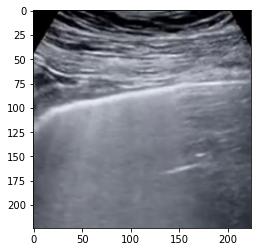

In [19]:
test_img = (vid.image_arr[3].copy() * 255).astype(np.uint8)
plt.imshow(test_img)
plt.show()

127


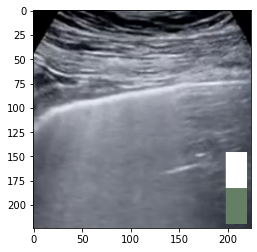

153


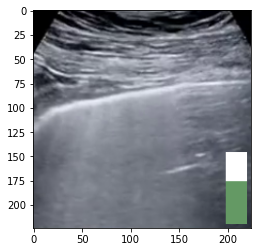

191


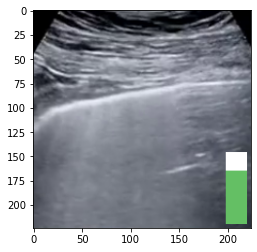

229


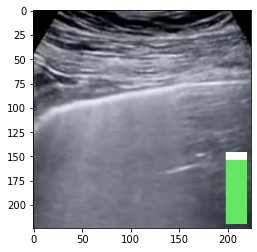

In [32]:
x_len, y_len,_ = test_img.shape
block_width = y_len//10
block_height = x_len//3
border = x_len//50

left = -border-block_width
right = -border
bottom = -border
for height in [0.5, 0.6, 0.75, 0.9]:
    test_img[bottom-block_height:bottom, left:right] = [255, 255, 255]
    normed_col_val = int(height*255)
    normed_height_val = int(height*block_height)
    print(normed_col_val)
    test_img[bottom-normed_height_val:bottom, left:right] = [100, normed_col_val, 100]
    plt.imshow(test_img)
    plt.show()

In [ ]:
vid.image_arr.shape

In [7]:
test_model = vid.models[0]

In [10]:
test_model.layers[-1].output_shape[1]

(None, 4)

In [ ]:
test_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(0.01), metrics=['accuracy'])

In [ ]:
fake_labels = np.zeros((5,4))
fake_labels[:,0] = 1
test_model.fit(vid.image_arr[:5],fake_labels

In [ ]:
fake_data.shape

In [ ]:
f = K.function([test_model.layers[0].input, K.learning_phase()], [test_model.layers[-1].output])
# K.set_learning_phase(1)
# for f_img in fake_data:
#     print(f([np.asarray([f_img])]))

In [ ]:
fake_data = [vid.image_arr[0] for _ in range(4)]

In [ ]:
test_model.predict(np.asarray(fake_data))

## Create Gauges

This notebook creates the precision overlays with a tachomoter-style gauge. 

In [3]:
import plotly.graph_objects as go
from PIL import Image, ImageDraw, ImageFont
import numpy as np
#import matplotlib.pyplot as plt
from matplotlib import cm

# if we're in the notebooks directory, go up by one
import os 
if os.getcwd().find('notebooks') != -1:
    os.chdir('..')

# create color map
cmap = cm.get_cmap('RdYlGn', 12)

# create overlay for every %-value
for precision in range(101):
    
    # open a new canvas using pillow. Note hardcoded dimensions, also in cam.py
    base = Image.new('RGBA', (1000,1000), (0,0,0,255))
    
    precision /=100
    value = np.round(precision*100, 0).astype(int)
    
    # create tachomter-style gauge
    color = f'rgb{cmap(precision**2)[:3]}'
    fig = go.Figure(go.Indicator(

        mode = "gauge+number",
        value = value,
        domain = {'x': [0, 1], 'y': [0, 1]},
        title = {'text': "Precision (%)", 'font': {'size': 40}},
        gauge = {
            'shape': 'angular',
            'axis': {'range': [None, 100], 'tickwidth': 5, 'tickcolor': "white"},
            'bar': {'color': color, 
                    'thickness': 1},
            'bgcolor': "black",
            'borderwidth': 4,
            'bordercolor': "white",
            }))

    fig.update_layout(paper_bgcolor = "black", 
                      font = {'color': 'white', 'family': "Arial", 'size':40})
                      #width = 1500, height = 1000,
                      #margin=dict(l=20, r=20, t=20, b=20))

    # save gauge
    file_name = f"precision_overlays/overlay_{str(value).zfill(3)}.png"
    fig.write_image(file_name)
    
    # reopen gauge using pillow
    gauge = Image.open(file_name)
    gauge = gauge.resize((350,250))
    
    # paste onto (1000,1000) canvas and save
    base.paste(gauge, (600,750))   
    base.save(file_name)